In [1]:
!pip install rxn4chemistry rdkit


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
api_key = 'apk-1ae423a5e9fde28976698d0f8f90cf543985fb0ff54004766a80715e15b56b88' # получить бесплатный ключ можно тут https://rxn.res.ibm.com/rxn/user/profile [ или используйте наш :) ]

In [3]:
from rxn4chemistry import RXN4ChemistryWrapper

In [37]:
rxn4chemistry_wrapper = RXN4ChemistryWrapper(api_key=api_key)
rxn4chemistry_wrapper.create_project('neftecode_retrosynthesis')

print(rxn4chemistry_wrapper.project_id)

67fa19b5e0c12569dca8514c


In [8]:
smiles = 'C1=CC=C(C=C1)NC2=CC=CC=C2'
response = rxn4chemistry_wrapper.predict_automatic_retrosynthesis(product=smiles, ai_model='2019-09-12')

In [24]:
results = rxn4chemistry_wrapper.get_predict_automatic_retrosynthesis_results(response['prediction_id'])
results['status']

'SUCCESS'

Showing path 0 with confidence 0.958:


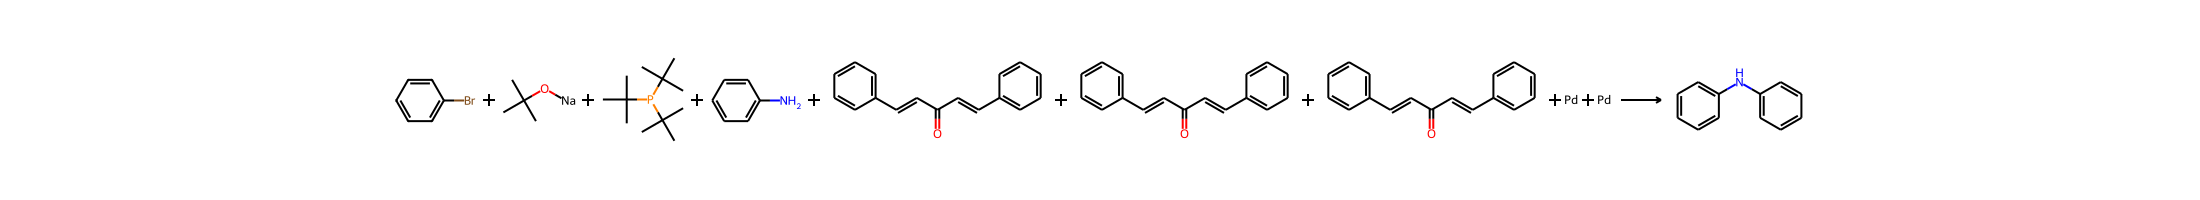

Showing path 1 with confidence 0.955:


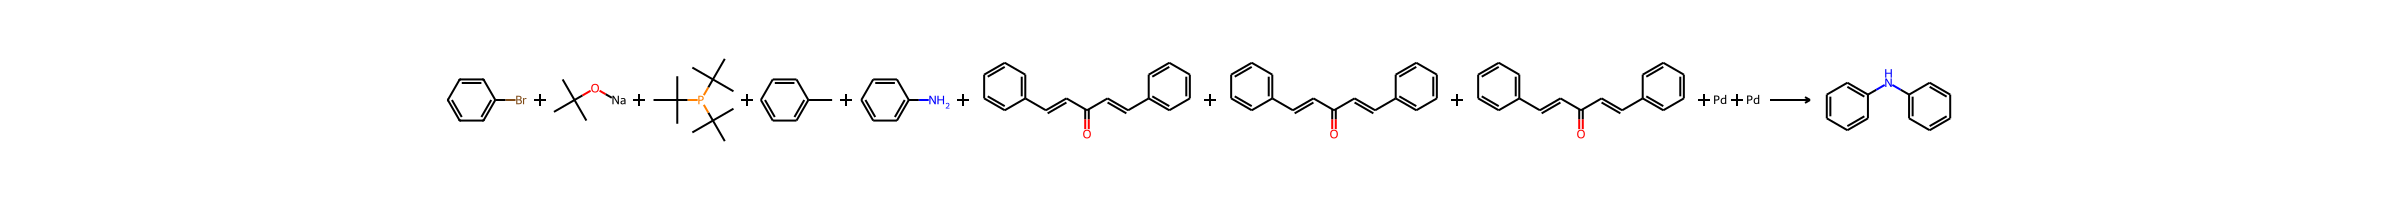

Showing path 2 with confidence 0.955:


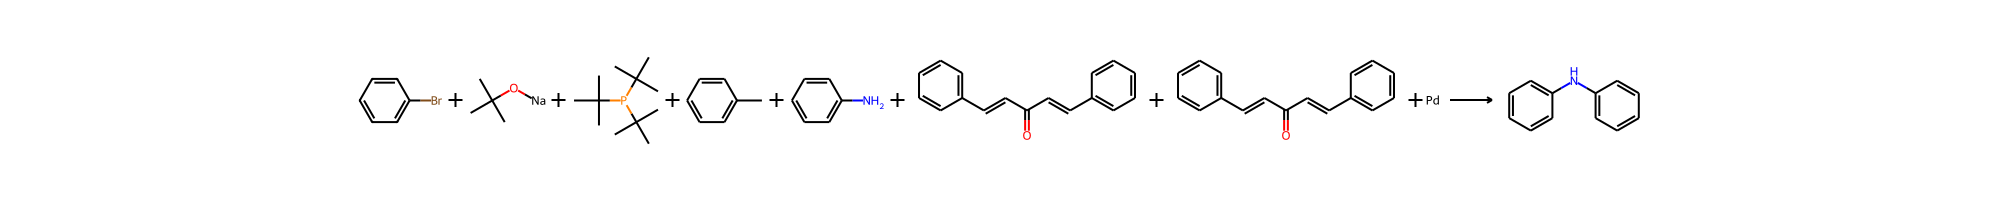

Showing path 3 with confidence 0.949:


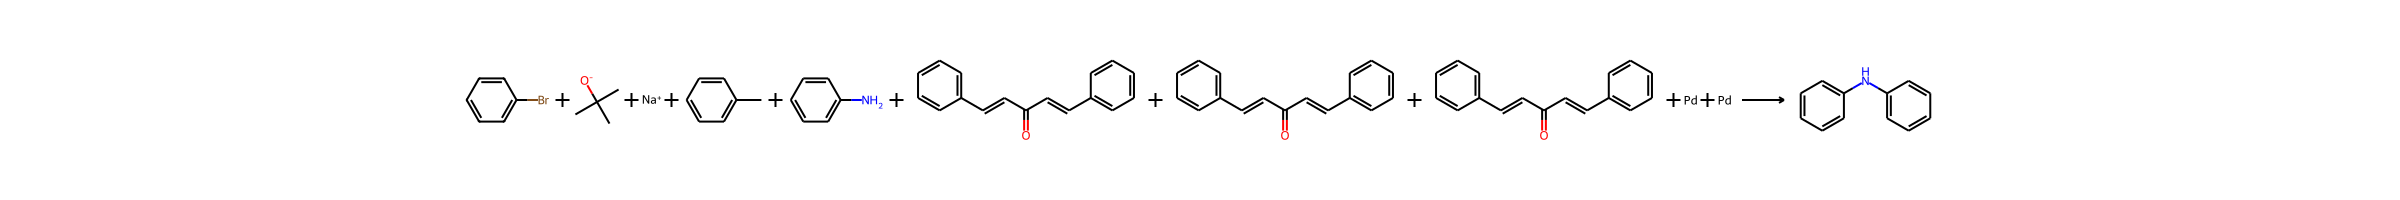

Showing path 4 with confidence 0.949:


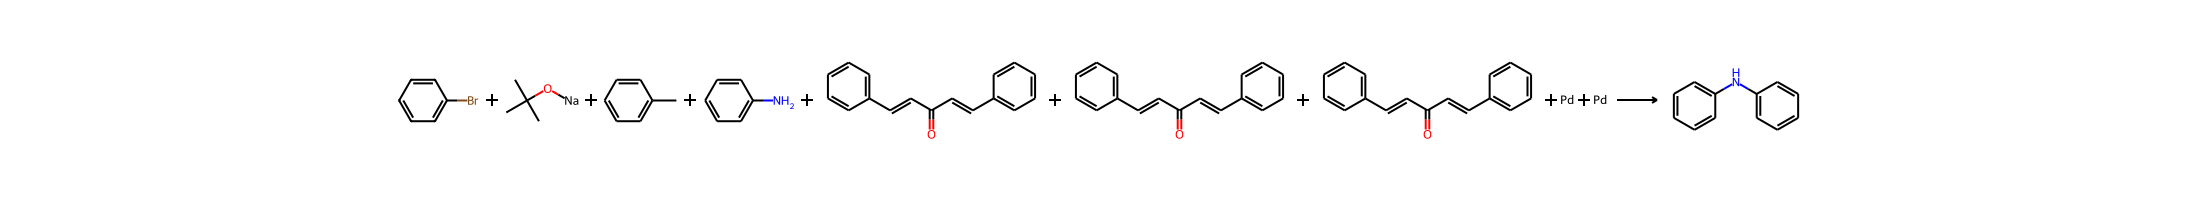

Showing path 5 with confidence 0.941:


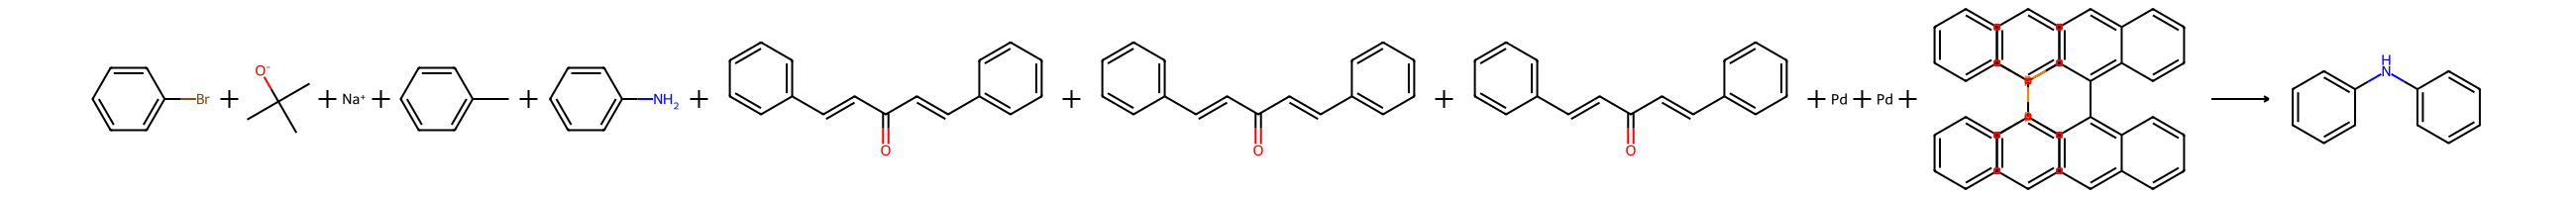

Showing path 6 with confidence 0.94:


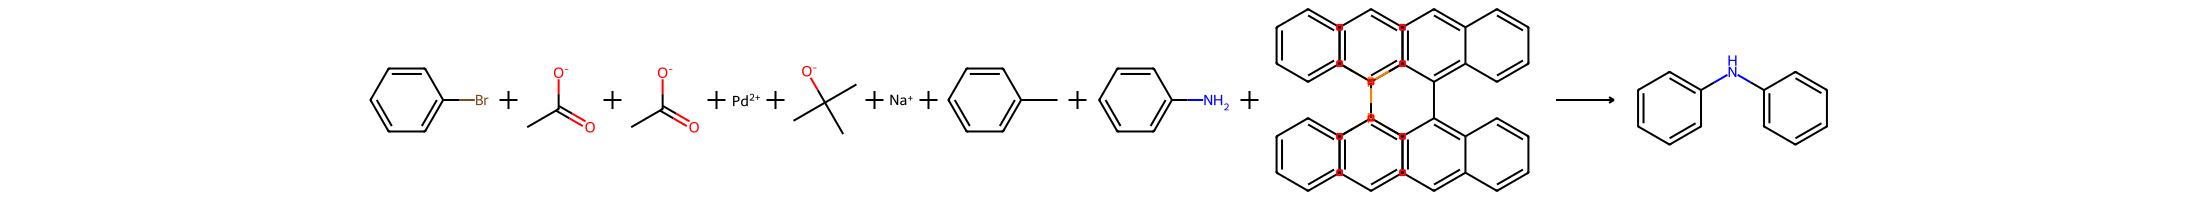

Showing path 7 with confidence 0.934:


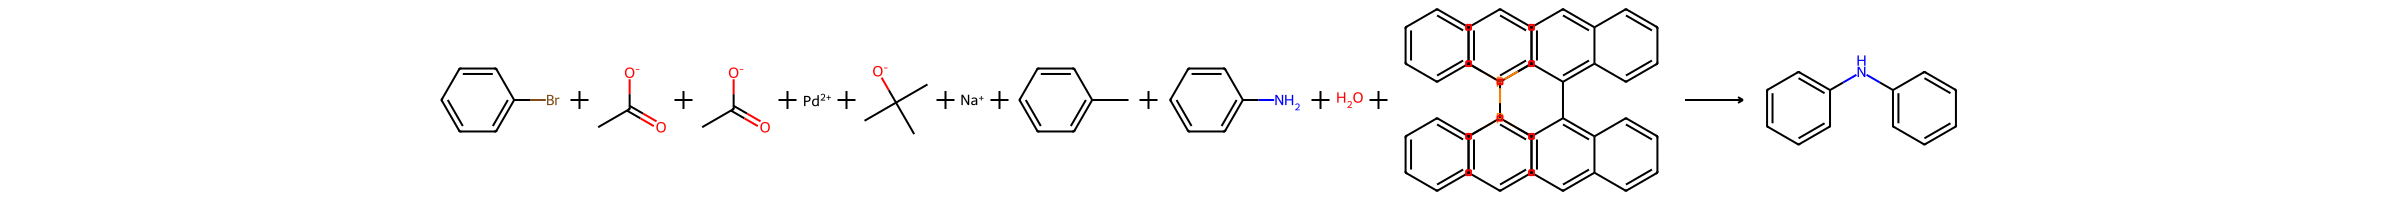

Showing path 8 with confidence 0.93:


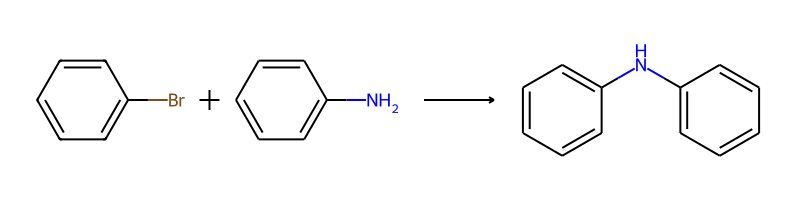

Showing path 9 with confidence 0.926:


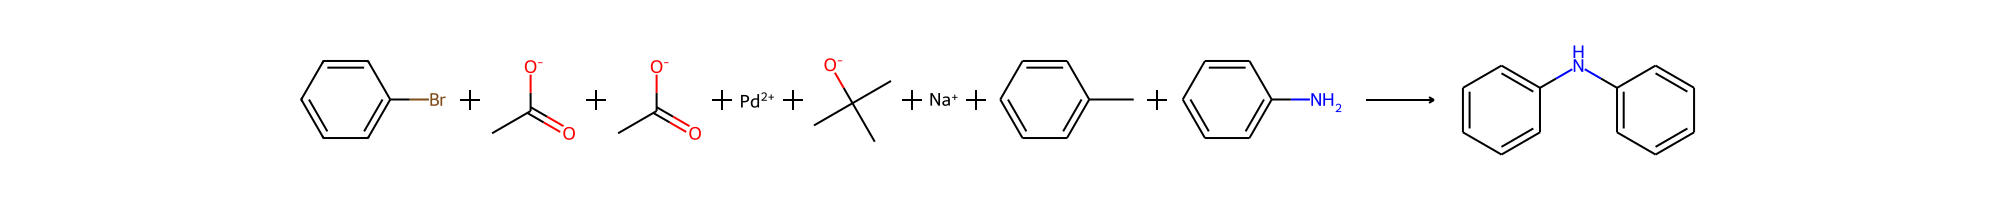

Showing path 10 with confidence 0.926:


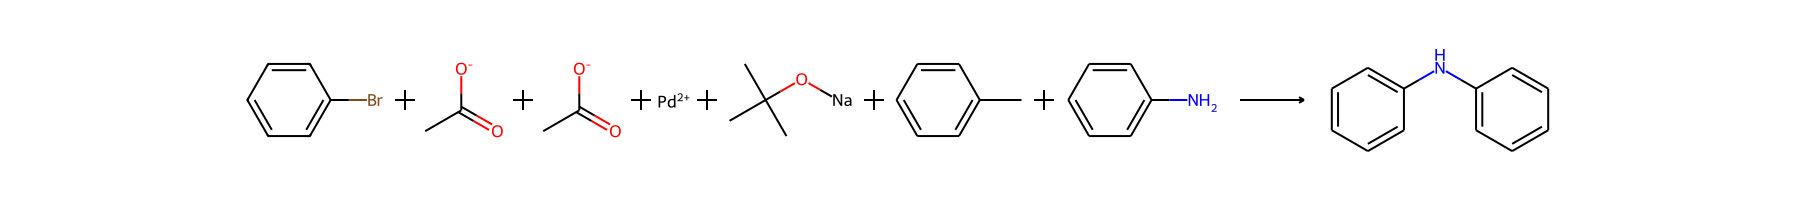

Showing path 11 with confidence 0.8:


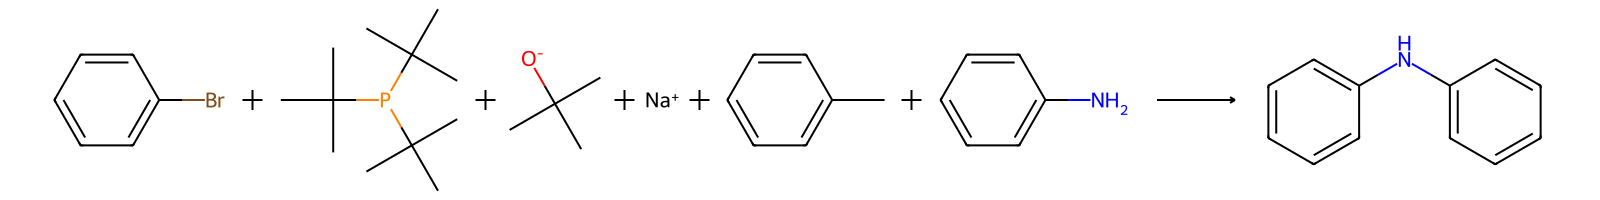

Showing path 12 with confidence 0.741:


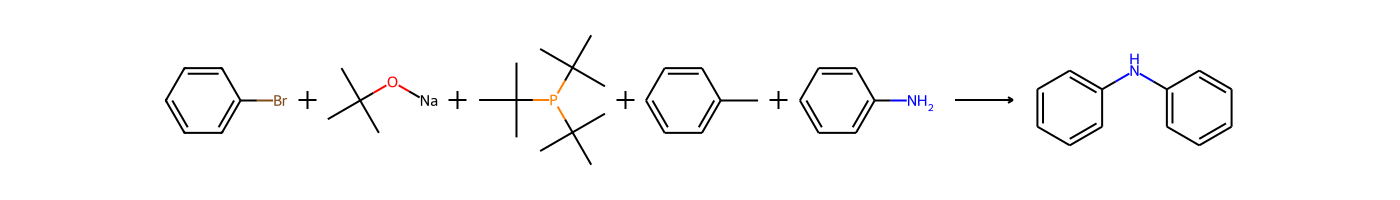

In [25]:
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import display

def collect_reactions(tree):
    reactions = []
    if 'children' in tree and len(tree['children']):
        reactions.append(
            AllChem.ReactionFromSmarts('{}>>{}'.format(
                '.'.join([node['smiles'] for node in tree['children']]),
                tree['smiles']
            ), useSmiles=True)
        )
    for node in tree['children']:
        reactions.extend(collect_reactions(node))
    return reactions

for index, path in enumerate(results['retrosynthetic_paths']):
    print('Showing path {} with confidence {}:'.format(index, path['confidence']))
    for reaction in collect_reactions(path):
        display(Chem.Draw.ReactionToImage(reaction))

In [38]:
import os
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

N_TO_TEST = 5 # берем первые 5 сгенерированных SMILES из каждого txt файла

def process_file(file_path, output_dir):
    file_name = os.path.basename(file_path)
    file_index = file_name.replace('valid_generated_molecules_', '').replace('.txt', '')
    print(f"Processing file: {file_name}")
    
    with open(file_path, 'r') as f:
        smiles_list = [line.strip() for line in f.readlines() if line.strip()]
    
    smiles_to_process = smiles_list[:N_TO_TEST]
    print(f"Found {len(smiles_to_process)} SMILES to process")
    
    for i, smiles in enumerate(smiles_to_process):
        process_smiles(smiles, output_dir, file_index, i)

def process_smiles(smiles, output_dir, file_index, smiles_index, max_retries=3, retry_delay=5):
    print(f"\nProcessing SMILES {smiles_index+1}: {smiles}")
    
    retries = 0
    success = False
    
    while not success and retries <= max_retries:
        if retries > 0:
            print(f"Retry #{retries} for SMILES {smiles_index+1}: {smiles}")
            time.sleep(retry_delay)
            
        try:
            rxn4chemistry_wrapper = RXN4ChemistryWrapper(api_key=api_key)
            rxn4chemistry_wrapper.create_project(f'neftecode_retrosynthesis_smiles{smiles_index}')
            # print(rxn4chemistry_wrapper.project_id)
            response = rxn4chemistry_wrapper.predict_automatic_retrosynthesis(
                product=smiles, 
                ai_model='2019-09-12'
            )
            prediction_id = response['prediction_id']
            print(f"Prediction ID: {prediction_id}")

            status = ""
            while status != "SUCCESS":
                results = rxn4chemistry_wrapper.get_predict_automatic_retrosynthesis_results(prediction_id)
                
                if results is None:
                    raise Exception("API returned None result")
                    
                status = results.get('status', '')
                
                if status == "SUCCESS":
                    break
                    
                if status == "FAILURE" or status == "ERROR":
                    print(f"API returned error status: {status}")
                    raise Exception(f"API error: {status}")
                    
                time.sleep(1)

            time.sleep(2)
            
            if 'retrosynthetic_paths' not in results or results['retrosynthetic_paths'] is None:
                raise Exception("No retrosynthetic paths found")
            
            result_dir = os.path.join(output_dir, f"file_{file_index}")
            os.makedirs(result_dir, exist_ok=True)
            
            result_file = os.path.join(result_dir, f"smiles_{smiles_index+1}_results.txt")
            with open(result_file, 'w') as f:
                f.write(f"SMILES: {smiles}\n")
                f.write(f"Prediction ID: {prediction_id}\n")
                f.write(f"Number of paths: {len(results['retrosynthetic_paths'])}\n\n")
                
                for path_idx, path in enumerate(results['retrosynthetic_paths']):
                    confidence = path['confidence']
                    f.write(f"Path {path_idx+1} - Confidence: {confidence}\n")
                    
                    reactions = collect_reactions(path)
                    f.write(f"Number of reactions: {len(reactions)}\n\n")
                    
                    for rxn_idx, reaction in enumerate(reactions):
                        img = Chem.Draw.ReactionToImage(reaction)
                        
                        plt.figure(figsize=(10, 5))
                        plt.imshow(img)
                        plt.axis('off')
                        plt.title(f"Path {path_idx+1} - Confidence: {confidence:.4f}")
                        
                        img_path = os.path.join(
                            result_dir, 
                            f"smiles_{smiles_index+1}_path_{path_idx+1}_rxn_{rxn_idx+1}.png"
                        )
                        plt.savefig(img_path, bbox_inches='tight')
                        plt.close()
            
            print(f"Successfully processed SMILES {smiles_index+1}")
            success = True
            
        except Exception as e:
            retries += 1
            print(f"Error processing SMILES {smiles_index+1} (attempt {retries}/{max_retries}): {str(e)}")
            if retries > max_retries:
                print(f"Failed to process SMILES {smiles_index+1} after {max_retries} attempts")
    
    print("Waiting 2 seconds before the next SMILES...")
    time.sleep(2)

base_dir = "SPMM/valid_molecules"
output_dir = "SPMM/retrosynthesis_results"

os.makedirs(output_dir, exist_ok=True)

files = [os.path.join(base_dir, f) for f in os.listdir(base_dir) 
            if f.startswith("valid_generated_molecules_") and f.endswith(".txt")]

for file_path in tqdm(files):
    process_file(file_path, output_dir)

  0%|          | 0/13 [00:00<?, ?it/s]

Processing file: valid_generated_molecules_0.txt
Found 5 SMILES to process

Processing SMILES 1: C=Cc1ccc(-c2cc[nH]c2)cc1
Prediction ID: 67fa19e1e0c12569dca85508
Error processing SMILES 1 (attempt 1/3): 'NoneType' object has no attribute 'get'
Retry #1 for SMILES 1: C=Cc1ccc(-c2cc[nH]c2)cc1
Prediction ID: 67fa1a04e0c12569dca859a2
Error processing SMILES 1 (attempt 2/3): 'NoneType' object has no attribute 'get'
Retry #2 for SMILES 1: C=Cc1ccc(-c2cc[nH]c2)cc1
Prediction ID: 67fa1a22e0c12569dca85dca
Error processing SMILES 1 (attempt 3/3): 'NoneType' object has no attribute 'get'
Retry #3 for SMILES 1: C=Cc1ccc(-c2cc[nH]c2)cc1
Prediction ID: 67fa1a3fe0c12569dca861e3
Successfully processed SMILES 1
Waiting 2 seconds before the next SMILES...

Processing SMILES 2: C=Cc1[nH]c2ccccc2c1C=C
Prediction ID: 67fa1a73e0c12569dca86770
Successfully processed SMILES 2
Waiting 2 seconds before the next SMILES...

Processing SMILES 3: Cc1ccc(Nc2ccccc2)cc1
Prediction ID: 67fa1a8be0c12569dca86a04
Successf

  8%|▊         | 1/13 [04:14<50:57, 254.82s/it]

Processing file: valid_generated_molecules_1.txt
Found 5 SMILES to process

Processing SMILES 1: CCCc1cc(CC)c(C(NC)c2cccc3ccccc23)c(CC)c1
Prediction ID: 67fa1adfe0c12569dca8727c
Successfully processed SMILES 1
Waiting 2 seconds before the next SMILES...

Processing SMILES 2: CCCCCCc1ccc(-c2ccc(Nc3ccc(C)cc3)cc2)nc1
Prediction ID: 67fa1b13e0c12569dca87799
Error processing SMILES 2 (attempt 1/3): 'NoneType' object has no attribute 'get'
Retry #1 for SMILES 2: CCCCCCc1ccc(-c2ccc(Nc3ccc(C)cc3)cc2)nc1
Prediction ID: 67fa1b3ce0c12569dca87c14
Error processing SMILES 2 (attempt 2/3): 'NoneType' object has no attribute 'get'
Retry #2 for SMILES 2: CCCCCCc1ccc(-c2ccc(Nc3ccc(C)cc3)cc2)nc1
Prediction ID: 67fa1b61e0c12569dca88084
Error processing SMILES 2 (attempt 3/3): 'NoneType' object has no attribute 'get'
Retry #3 for SMILES 2: CCCCCCc1ccc(-c2ccc(Nc3ccc(C)cc3)cc2)nc1
Prediction ID: 67fa1b81e0c12569dca88483
Error processing SMILES 2 (attempt 4/3): 'NoneType' object has no attribute 'get'
Failed 

 15%|█▌        | 2/13 [10:59<1:02:53, 343.04s/it]

Processing file: valid_generated_molecules_10.txt
Found 5 SMILES to process

Processing SMILES 1: CCCCN(CCCC)CC(O)CNCc1ccc(-n2cccc2)cc1
Prediction ID: 67fa1c74e0c12569dca8a361
Successfully processed SMILES 1
Waiting 2 seconds before the next SMILES...

Processing SMILES 2: CCCCN(CCO)Cc1ccc(CNCc2cccc(OC)c2)cc1
Prediction ID: 67fa1caae0c12569dca8a981
Successfully processed SMILES 2
Waiting 2 seconds before the next SMILES...

Processing SMILES 3: CCNC(=NCC(Cc1ccccc1)N(C)C)NCCc1ccco1
Prediction ID: 67fa1ceae0c12569dca8b19b
Successfully processed SMILES 3
Waiting 2 seconds before the next SMILES...

Processing SMILES 4: CCN(CC)c1ccc(N(Cc2ccc(O)c(O)c2)C(C)C)cc1
Prediction ID: 67fa1d19e0c12569dca8b727
Successfully processed SMILES 4
Waiting 2 seconds before the next SMILES...

Processing SMILES 5: CCc1ccc(NC(c2cccc(OC)c2O)N(C)CCC(C)C)cc1
Prediction ID: 67fa1d51e0c12569dca8bdd9
Successfully processed SMILES 5
Waiting 2 seconds before the next SMILES...


 23%|██▎       | 3/13 [15:04<49:40, 298.06s/it]  

Processing file: valid_generated_molecules_11.txt
Found 5 SMILES to process

Processing SMILES 1: CCCCCCCNC(=S)NCc1cccc(CN(CCCCC)CCCC)c1
Prediction ID: 67fa1d69e0c12569dca8c039
Successfully processed SMILES 1
Waiting 2 seconds before the next SMILES...

Processing SMILES 2: CCCCCCCCCCCc1c(O)cc(O)cc1CCCCCC
Prediction ID: 67fa1d8be0c12569dca8c341
Successfully processed SMILES 2
Waiting 2 seconds before the next SMILES...

Processing SMILES 3: CCCCCCCCC(CNC(=S)Nc1ccccc1)N(C)Cc1cccc(OC)c1
Prediction ID: 67fa1da8e0c12569dca8c61e
Successfully processed SMILES 3
Waiting 2 seconds before the next SMILES...

Processing SMILES 4: CCCCCCCc1c(C)cc(O)c(OCCCCC)c1CCCCCNCCCC
Prediction ID: 67fa1dd5e0c12569dca8cba3
Successfully processed SMILES 4
Waiting 2 seconds before the next SMILES...

Processing SMILES 5: CCCCCCCCCCCCCCC(CO)Nc1ccc(-c2ccc(OC)cc2)cn1
Prediction ID: 67fa1e15e0c12569dca8d4e7
Error processing SMILES 5 (attempt 1/3): 'NoneType' object has no attribute 'get'
Retry #1 for SMILES 5: CCCCC

 31%|███       | 4/13 [20:15<45:29, 303.26s/it]

Processing file: valid_generated_molecules_12.txt
Found 5 SMILES to process

Processing SMILES 1: CCC(C)NC(=O)CCN(CCOC)Cc1ccccc1
Prediction ID: 67fa1ea0e0c12569dca8e7ac
Successfully processed SMILES 1
Waiting 2 seconds before the next SMILES...

Processing SMILES 2: CCCCN(CCNC(C)=O)Cc1ccc(OC)cc1
Prediction ID: 67fa1ecbe0c12569dca8ed01
Successfully processed SMILES 2
Waiting 2 seconds before the next SMILES...

Processing SMILES 3: CCCNC(=O)COc1cc(CN(CC)CC)ccc1OC
Prediction ID: 67fa1efde0c12569dca8f307
Successfully processed SMILES 3
Waiting 2 seconds before the next SMILES...

Processing SMILES 4: COCCn1c(CCNC(=O)CC(C)C)ccc1C(C)(C)C
Prediction ID: 67fa1f35e0c12569dca8f9b4
Successfully processed SMILES 4
Waiting 2 seconds before the next SMILES...

Processing SMILES 5: CCC(=O)NCCOCCOc1c(C)cc(C)cc1C
Prediction ID: 67fa1f68e0c12569dca90020
Error processing SMILES 5 (attempt 1/3): 'NoneType' object has no attribute 'get'
Retry #1 for SMILES 5: CCC(=O)NCCOCCOc1c(C)cc(C)cc1C
Prediction ID: 6

 38%|███▊      | 5/13 [25:24<40:43, 305.40s/it]

Processing file: valid_generated_molecules_2.txt
Found 5 SMILES to process

Processing SMILES 1: CCCCCCCCCCc1cc2ccc(NCCCCCC)cc2n1CCN(C)C
Prediction ID: 67fa1fd5e0c12569dca90d77
Successfully processed SMILES 1
Waiting 2 seconds before the next SMILES...

Processing SMILES 2: CCNc1nc(C)cc(-c2ccc(CN(CCC)CCCC)c(CC)c2)c1C
Prediction ID: 67fa1ff8e0c12569dca91244
Successfully processed SMILES 2
Waiting 2 seconds before the next SMILES...

Processing SMILES 3: CCCCN(CCCC)c1ccc(-c2ccc(CNCCCCCC)cc2)nc1
Prediction ID: 67fa2051e0c12569dca91d39
Successfully processed SMILES 3
Waiting 2 seconds before the next SMILES...

Processing SMILES 4: CCCCCCCCN(CCCC)Cc1cn[nH]c1-c1c(C)cc(C)cc1C
Prediction ID: 67fa20a9e0c12569dca9278d
Error processing SMILES 4 (attempt 1/3): 'NoneType' object has no attribute 'get'
Retry #1 for SMILES 4: CCCCCCCCN(CCCC)Cc1cn[nH]c1-c1c(C)cc(C)cc1C
Prediction ID: 67fa20e7e0c12569dca92f98
Error processing SMILES 4 (attempt 2/3): 'NoneType' object has no attribute 'get'
Retry #2 fo

 46%|████▌     | 6/13 [32:48<41:08, 352.63s/it]

Processing file: valid_generated_molecules_3.txt
Found 5 SMILES to process

Processing SMILES 1: c1ccc(Nc2cccc3ccccc23)cc1
Prediction ID: 67fa2192e0c12569dca94377
Successfully processed SMILES 1
Waiting 2 seconds before the next SMILES...

Processing SMILES 2: c1cncc(-c2c[nH]c3ccccc23)c1
Prediction ID: 67fa21afe0c12569dca94684
Successfully processed SMILES 2
Waiting 2 seconds before the next SMILES...

Processing SMILES 3: c1ccc(-c2cc3ccccc3[nH]2)cc1
Prediction ID: 67fa21e0e0c12569dca94c33
Successfully processed SMILES 3
Waiting 2 seconds before the next SMILES...

Processing SMILES 4: c1ccc(Nc2cccc3cccnc23)cc1
Prediction ID: 67fa2206e0c12569dca95057
Successfully processed SMILES 4
Waiting 2 seconds before the next SMILES...

Processing SMILES 5: C(=Cc1cc2ccccc2[nH]1)c1cccnc1
Prediction ID: 67fa2225e0c12569dca953b7
Successfully processed SMILES 5
Waiting 2 seconds before the next SMILES...


 54%|█████▍    | 7/13 [35:46<29:31, 295.31s/it]

Processing file: valid_generated_molecules_4.txt
Found 5 SMILES to process

Processing SMILES 1: CNCc1ccc(C)cc1
Prediction ID: 67fa2243e0c12569dca9570e
Successfully processed SMILES 1
Waiting 2 seconds before the next SMILES...

Processing SMILES 2: Cc1ccc(C)c(O)c1
Prediction ID: 67fa2261e0c12569dca95a5b
Successfully processed SMILES 2
Waiting 2 seconds before the next SMILES...

Processing SMILES 3: Cc1ccc(CO)cc1
Prediction ID: 67fa227de0c12569dca95cfb
Successfully processed SMILES 3
Waiting 2 seconds before the next SMILES...

Processing SMILES 4: Cc1cccc(O)c1C
Prediction ID: 67fa2293e0c12569dca95f2b
Error processing SMILES 4 (attempt 1/3): Too frequent requests. Wait at least 1e-05s between consecutive requests to the API
Retry #1 for SMILES 4: Cc1cccc(O)c1C
Error processing SMILES 4 (attempt 2/3): Too frequent requests. Wait at least 1e-05s between consecutive requests to the API
Retry #2 for SMILES 4: Cc1cccc(O)c1C
Error processing SMILES 4 (attempt 3/3): Too frequent requests. Wa

 62%|██████▏   | 8/13 [38:27<21:02, 252.52s/it]

Processing file: valid_generated_molecules_5.txt
Found 5 SMILES to process

Processing SMILES 1: CCc1cc(C)c(O)cc1
Prediction ID: 67fa22f1e0c12569dca96854
Successfully processed SMILES 1
Waiting 2 seconds before the next SMILES...

Processing SMILES 2: C=CCc1cc(C)[nH]n1
Prediction ID: 67fa231ee0c12569dca96d70
Successfully processed SMILES 2
Waiting 2 seconds before the next SMILES...

Processing SMILES 3: CCc1ccc(O)cc1
Prediction ID: 67fa2364e0c12569dca975b7
Successfully processed SMILES 3
Waiting 2 seconds before the next SMILES...

Processing SMILES 4: CCc1cc(C)c(O)cc1
Prediction ID: 67fa2383e0c12569dca978d7
Error processing SMILES 4 (attempt 1/3): 'NoneType' object has no attribute 'get'
Retry #1 for SMILES 4: CCc1cc(C)c(O)cc1
Prediction ID: 67fa239fe0c12569dca97c13
Error processing SMILES 4 (attempt 2/3): 'NoneType' object has no attribute 'get'
Retry #2 for SMILES 4: CCc1cc(C)c(O)cc1
Prediction ID: 67fa23b5e0c12569dca97e83
Successfully processed SMILES 4
Waiting 2 seconds before th

 69%|██████▉   | 9/13 [42:43<16:55, 253.77s/it]

Processing file: valid_generated_molecules_6.txt
Found 5 SMILES to process

Processing SMILES 1: CCc1cccc(O)c1
Prediction ID: 67fa23f1e0c12569dca984ff
Successfully processed SMILES 1
Waiting 2 seconds before the next SMILES...

Processing SMILES 2: Cc1ccc(CO)c(C)c1
Prediction ID: 67fa240ee0c12569dca98854
Successfully processed SMILES 2
Waiting 2 seconds before the next SMILES...

Processing SMILES 3: COCCc1ccccc1O
Prediction ID: 67fa2424e0c12569dca98b3d
Successfully processed SMILES 3
Waiting 2 seconds before the next SMILES...

Processing SMILES 4: C=CCc1ccc(O)cc1
Prediction ID: 67fa244be0c12569dca9911b
Successfully processed SMILES 4
Waiting 2 seconds before the next SMILES...

Processing SMILES 5: CCc1cccc(O)c1
Prediction ID: 67fa2469e0c12569dca9945f
Successfully processed SMILES 5
Waiting 2 seconds before the next SMILES...


 77%|███████▋  | 10/13 [45:02<10:55, 218.34s/it]

Processing file: valid_generated_molecules_7.txt
Found 5 SMILES to process

Processing SMILES 1: Cc1cccc(CO)c1
Prediction ID: 67fa247ce0c12569dca996a6
Successfully processed SMILES 1
Waiting 2 seconds before the next SMILES...

Processing SMILES 2: CC(=N)c1cccnc1
Prediction ID: 67fa2494e0c12569dca99980
Successfully processed SMILES 2
Waiting 2 seconds before the next SMILES...

Processing SMILES 3: CNc1cc(C)c(C)cn1
Prediction ID: 67fa24aee0c12569dca99c29
Successfully processed SMILES 3
Waiting 2 seconds before the next SMILES...

Processing SMILES 4: CC(=N)c1ccccc1C
Prediction ID: 67fa24c5e0c12569dca99eab
Successfully processed SMILES 4
Waiting 2 seconds before the next SMILES...

Processing SMILES 5: CCc1cc(C)c(O)cn1
Prediction ID: 67fa24dfe0c12569dca9a142
Successfully processed SMILES 5
Waiting 2 seconds before the next SMILES...


 85%|████████▍ | 11/13 [47:26<06:31, 195.53s/it]

Processing file: valid_generated_molecules_8.txt
Found 5 SMILES to process

Processing SMILES 1: C#Cc1ccc(CO)c(C)c1
Prediction ID: 67fa250ce0c12569dca9a7b6
Successfully processed SMILES 1
Waiting 2 seconds before the next SMILES...

Processing SMILES 2: N#Cc1ccc(CO)cc1
Prediction ID: 67fa253ce0c12569dca9ae0a
Successfully processed SMILES 2
Waiting 2 seconds before the next SMILES...

Processing SMILES 3: Cc1cc(C)cc(CO)c1
Prediction ID: 67fa255ae0c12569dca9b150
Successfully processed SMILES 3
Waiting 2 seconds before the next SMILES...

Processing SMILES 4: Cc1cc(C)cc(O)c1
Prediction ID: 67fa2577e0c12569dca9b475
Successfully processed SMILES 4
Waiting 2 seconds before the next SMILES...

Processing SMILES 5: Cc1ccc(CO)cc1
Prediction ID: 67fa2593e0c12569dca9b71c
Successfully processed SMILES 5
Waiting 2 seconds before the next SMILES...


 92%|█████████▏| 12/13 [50:03<03:03, 183.75s/it]

Processing file: valid_generated_molecules_9.txt
Found 5 SMILES to process

Processing SMILES 1: CCCC(C)NC(C)c1ccccc1OC
Prediction ID: 67fa25a9e0c12569dca9b986
Successfully processed SMILES 1
Waiting 2 seconds before the next SMILES...

Processing SMILES 2: Cc1cc(C)c(CNCCOC(C)C)c(C)c1
Prediction ID: 67fa25c9e0c12569dca9bcc9
Successfully processed SMILES 2
Waiting 2 seconds before the next SMILES...

Processing SMILES 3: CCc1ccc(C(C)NCC(C)C)cc1
Prediction ID: 67fa25e4e0c12569dca9bfc4
Successfully processed SMILES 3
Waiting 2 seconds before the next SMILES...

Processing SMILES 4: CCN(CC)CCCC(O)c1ccccc1
Prediction ID: 67fa25f9e0c12569dca9c281
Successfully processed SMILES 4
Waiting 2 seconds before the next SMILES...

Processing SMILES 5: CCCCCN(C)CC(O)c1ccccc1
Prediction ID: 67fa261ee0c12569dca9c72a
Successfully processed SMILES 5
Waiting 2 seconds before the next SMILES...


100%|██████████| 13/13 [52:36<00:00, 242.78s/it]


In [39]:
import os
import zipfile

def zip_directory(source_dir, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(source_dir):
            for file in files:
                file_path = os.path.join(root, file)
                archive_path = os.path.relpath(file_path, source_dir)
                zipf.write(file_path, archive_path)

zip_directory("SPMM/retrosynthesis_results", "retrosynthesis_results.zip")